In [1]:
from torchvision import datasets
import torch
data_folder = ''
fmnist = datasets.FashionMNIST(data_folder, download=True,train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [2]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x = x.float()
        x = x.view(-1, 28*28) / 255
        self.x, self.y = x,y
    def __getitem__(self,ix):
        x,y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [5]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28,1000),
        nn.ReLU(),
        nn.Linear(1000,1000),
        nn.ReLU(),
        nn.Linear(1000,10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=  1e-3)
    return model, loss_fn, optimizer

In [6]:
def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy_fn(x,y,model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [7]:
@torch.no_grad()
def val_loss(x,y,model):
    prediction = model(x)
    val_loss = loss_fn(prediction,y)
    return val_loss.item()

In [8]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32,shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [9]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer= get_model()

In [10]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        batch_loss = train_batch(x,y,model,optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy_fn(x,y,model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy_fn(x,y,model)
        validation_loss = val_loss(x,y,model)

    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


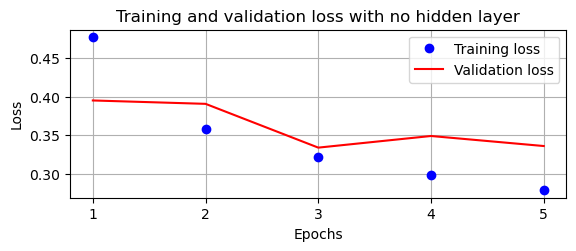

/tmp/ipykernel_18575/1890947205.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


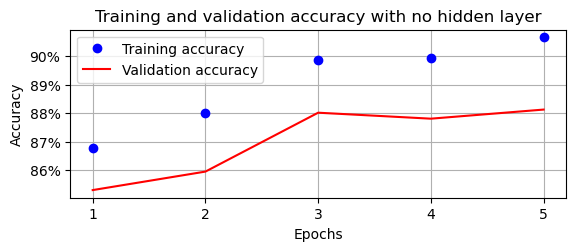

In [11]:
epochs = np.arange(5) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with no hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with no hidden layer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid(True)
plt.legend()
plt.show()